# Survival Analysis
## Exploring the effect of patient attributes on the probability of an event happening at a certain time within a hospital

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines as sa

from pathlib import Path
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index, k_fold_cross_validation
from lifelines.plotting import plot_lifetimes
from lifelines import CoxPHFitter
from ipywidgets import interact

## Data
All data in this notebook is dummy data, which is the indian liver patinet dataset found here: https://archive.ics.uci.edu/ml/datasets/ILPD+(Indian+Liver+Patient+Dataset) augmented with one dummy categorical feature.

Reference: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [4]:
data_path = 'data/dummy_data.csv'

In [5]:
data = pd.read_csv(data_path, index_col=0)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 582
Data columns (total 12 columns):
age                           579 non-null int64
gender                        579 non-null int64
total_bilirubin               579 non-null float64
direct_bilirubin              579 non-null float64
alkaline_phosphotase          579 non-null int64
alamine_aminotransferase      579 non-null int64
aspartate_aminotransferase    579 non-null int64
total_proteins                579 non-null float64
albumin                       579 non-null float64
albumin_and_globulin_ratio    579 non-null float64
liver_patient                 579 non-null int64
dummy_category                579 non-null object
dtypes: float64(5), int64(6), object(1)
memory usage: 58.8+ KB


Rename a column in the dummy dataset to create a dummy time-to-event column

In [10]:
data.rename(columns={'age': 'time_to_event'}, inplace=True)

In [11]:
target_variable = 'time_to_event'  # dummy categorical 
features = [col for col in data.columns if col is not target_variable]

In [12]:
features

['gender',
 'total_bilirubin',
 'direct_bilirubin',
 'alkaline_phosphotase',
 'alamine_aminotransferase',
 'aspartate_aminotransferase',
 'total_proteins',
 'albumin',
 'albumin_and_globulin_ratio',
 'liver_patient',
 'dummy_category',
 'observed']

All data is observed in this dataset 

In [13]:
data['observed'] = 1

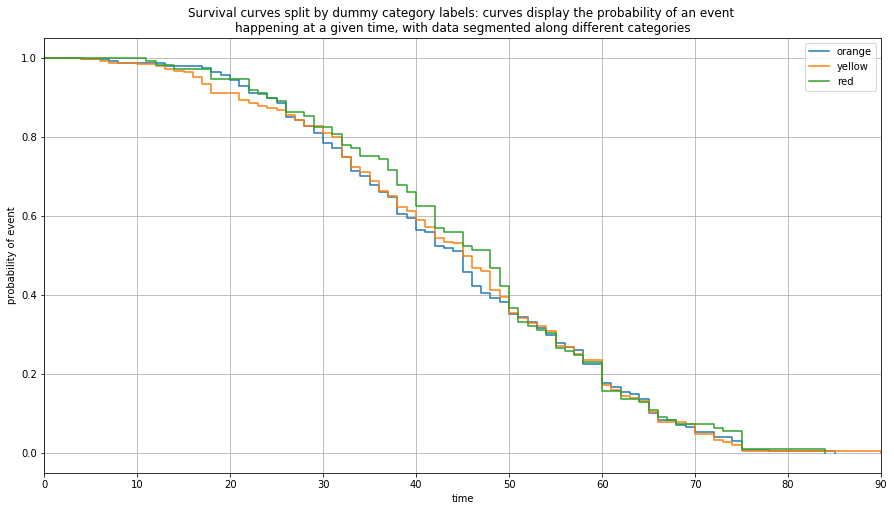

In [30]:
plt.rcParams['figure.figsize'] = 15, 8

ax = -1

for cat in data['dummy_category'].unique():
    kmf = KaplanMeierFitter()
    d = data[data['dummy_category']==cat]
    kmf.fit(d[target_variable], event_observed=d['observed'], label=cat)
    if ax==-1:
        ax=kmf.plot(ci_show=False)
    else:
        kmf.plot(ax=ax, ci_show=False)
plt.ylabel('probability of event happening after a given stretch of time')
plt.xlabel('time')
plt.title('Survival curves split by dummy category labels: curves display the probability of an event \n' +
          'happening after a given time, with data segmented along different categories')
plt.grid()
plt.show()

In [17]:
cpf = CoxPHFitter()
cpf.fit(data.drop('dummy_category', axis=1), duration_col='time_to_event', event_col='observed')

<lifelines.CoxPHFitter: fitted with 579 observations, 0 censored>

In [18]:
cpf.print_summary()

<lifelines.CoxPHFitter: fitted with 579 observations, 0 censored>
      duration col = 'time_to_event'
         event col = 'observed'
number of subjects = 579
  number of events = 579
partial log-likelihood = -3081.13
  time fit was run = 2019-09-22 20:42:38 UTC

---
                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
gender                     -0.08      0.93      0.10           -0.27            0.12                0.76                1.13
total_bilirubin             0.00      1.00      0.01           -0.02            0.03                0.98                1.03
direct_bilirubin            0.03      1.03      0.03           -0.03            0.09                0.97                1.10
alkaline_phosphotase       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
alamine_aminotransferase    0.00      1.00      0.00            0.00            0.00                1.00  

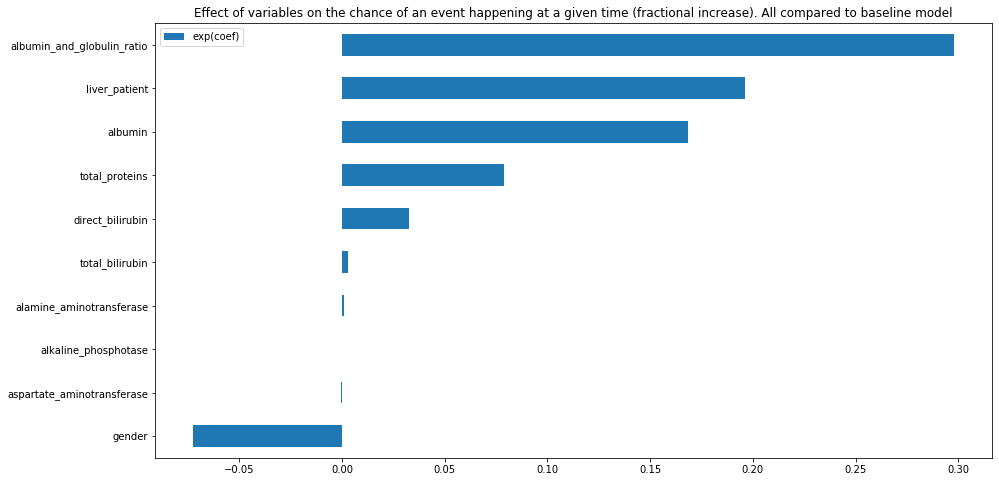

In [34]:
(cpf.summary[['exp(coef)']] - 1).sort_values('exp(coef)').plot.barh()
plt.title('Effect of variables on the chance of an event happening at a given time (fractional increase). All compared to baseline model')
plt.show()

Use interact with this

In [44]:
vars_to_isolate = data.drop(['dummy_category', 'time_to_event', 'observed'], axis=1).columns.values

def compare_effect_of_different_variables_on_time_to_event(variable_to_investigate):
    if len(data[variable_to_investigate].unique()) == 2:
        range_of_values = [0, 1]
    else:
        range_of_values = np.arange(data[variable_to_investigate].min(), data[variable_to_investigate].max(), 
                                    (data[variable_to_investigate].max()-data[variable_to_investigate].min())/5)
    cpf.plot_covariate_groups(variable_to_investigate, range_of_values)
    plt.ylabel('probability of event happening after a given stretch of time')
    plt.xlabel('time')
    plt.title(f'Survival curves for different values of {variable_to_investigate}')
    plt.show()
    
interact(compare_effect_of_different_variables_on_time_to_event, 
         variable_to_investigate=vars_to_isolate)

interactive(children=(Dropdown(description='variable_to_investigate', options=('gender', 'total_bilirubin', 'd…

<function __main__.compare_effect_of_different_variables_on_time_to_event(variable_to_investigate)>